# Deduplication

The best approach depends on your domain (don't assume that what everyone is doing to prep datasets for LLM pre-training is relevant for you)

The examples below aren't aiming to be as efficient as possible but show what different approaches you can take at a high level and what they result in.

In [ ]:
%pip install datasets datasketch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:
from datasets import load_dataset

In [ ]:
ag_dataset = load_dataset("ag_news", split="train")
ag_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:81: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

## Approach 0: Use metadata to deduplicate or stratify your data

Your data may already come with metadata (dates, categories, internal IDs...). For some tasks, you may want to keep all the data but for others, you may want to deduplicate it or stratify it based on the metadata. In particular if you know that the data you have collected for training doesn't match well the target distribution, you may want to oversample some categories or undersample others.

If we look at the AG News dataset, we can see we have labels. These might not be what we're using in

In [ ]:
ag_dataset[0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [ ]:
ag_dataset.features['label'].names

['World', 'Sports', 'Business', 'Sci/Tech']

In [ ]:
ag_df =  ag_dataset.to_pandas()
ag_df

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0
119996,Renteria signing a top-shelf deal Red Sox gene...,1
119997,Saban not going to Dolphins yet The Miami Dolp...,1
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1


In [ ]:
ag_df['label'].value_counts(normalize=True)

label
2    0.25
3    0.25
1    0.25
0    0.25
Name: proportion, dtype: float64

In this case the categories of news are evently distributed but we may have already decided that we'll use a different model for working with business news so we can remove most or all of that data from our dataset.

In [ ]:
sql_dataset = load_dataset("gretelai/synthetic_text_to_sql", split="train")
sql_dataset[0]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5851 [00:00<?, ? examples/s]

{'id': 5097,
 'domain': 'forestry',
 'domain_description': 'Comprehensive data on sustainable forest management, timber production, wildlife habitat, and carbon sequestration in forestry.',
 'sql_complexity': 'single join',
 'sql_complexity_description': 'only one join (specify inner, outer, cross)',
 'sql_task_type': 'analytics and reporting',
 'sql_task_type_description': 'generating reports, dashboards, and analytical insights',
 'sql_prompt': 'What is the total volume of timber sold by each salesperson, sorted by salesperson?',
 'sql_context': "CREATE TABLE salesperson (salesperson_id INT, name TEXT, region TEXT); INSERT INTO salesperson (salesperson_id, name, region) VALUES (1, 'John Doe', 'North'), (2, 'Jane Smith', 'South'); CREATE TABLE timber_sales (sales_id INT, salesperson_id INT, volume REAL, sale_date DATE); INSERT INTO timber_sales (sales_id, salesperson_id, volume, sale_date) VALUES (1, 1, 120, '2021-01-01'), (2, 1, 150, '2021-02-01'), (3, 2, 180, '2021-01-01');",
 'sql'

In [12]:
sql_df = sql_dataset.to_pandas()

In [13]:
sql_df

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation
0,5097,forestry,Comprehensive data on sustainable forest manag...,single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to...","Joins timber_sales and salesperson tables, gro..."
1,5098,defense industry,"Defense contract data, military equipment main...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen...",This query groups the equipment_maintenance ta...
2,5099,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...,This query counts the number of marine species...
3,5100,financial services,Detailed financial data including investment s...,aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)...",This query calculates the total trade value an...
4,5101,energy,Energy market data covering renewable energy s...,window functions,"window functions (e.g., ROW_NUMBER, LEAD, LAG,...",analytics and reporting,"generating reports, dashboards, and analytical...",Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW...",The SQL query uses the ROW_NUMBER function to ...
...,...,...,...,...,...,...,...,...,...,...,...
99995,89651,nonprofit,"Nonprofit data on charitable giving trends, so...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",Which programs had the highest volunteer parti...,"CREATE TABLE programs (program_id INT, num_vol...","SELECT program_id, (num_volunteers / total_par...",This query calculates the participation rate f...
99996,89652,retail,"Retail data on circular supply chains, ethical...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the number of fair-trade certified acc...,"CREATE TABLE products (product_id INT, product...",SELECT COUNT(*) FROM products WHERE is_fair_tr...,The query counts the number of fair-trade cert...
99997,89653,fitness industry,"Workout data, membership demographics, wearabl...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",Find the user with the longest workout session...,"CREATE TABLE workout_sessions (id INT, user_id...","SELECT u.name, MAX(session_duration) as max_du...",The query joins the workout_sessions and users...
99998,89654,space exploration,"Spacecraft manufacturing data, space mission r...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",How many space missions were completed by each...,"CREATE TABLE SpaceMissions (id INT, astronaut_...","SELECT a.name, COUNT(sm.id) FROM Astronauts a ...",This query calculates the number of space miss...


The recommended plots in google Colab can be quite helpful for lazily visualizing some features of your dataset

In [14]:
sql_df

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation
0,5097,forestry,Comprehensive data on sustainable forest manag...,single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to...","Joins timber_sales and salesperson tables, gro..."
1,5098,defense industry,"Defense contract data, military equipment main...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen...",This query groups the equipment_maintenance ta...
2,5099,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...,This query counts the number of marine species...
3,5100,financial services,Detailed financial data including investment s...,aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)...",This query calculates the total trade value an...
4,5101,energy,Energy market data covering renewable energy s...,window functions,"window functions (e.g., ROW_NUMBER, LEAD, LAG,...",analytics and reporting,"generating reports, dashboards, and analytical...",Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW...",The SQL query uses the ROW_NUMBER function to ...
...,...,...,...,...,...,...,...,...,...,...,...
99995,89651,nonprofit,"Nonprofit data on charitable giving trends, so...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",Which programs had the highest volunteer parti...,"CREATE TABLE programs (program_id INT, num_vol...","SELECT program_id, (num_volunteers / total_par...",This query calculates the participation rate f...
99996,89652,retail,"Retail data on circular supply chains, ethical...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the number of fair-trade certified acc...,"CREATE TABLE products (product_id INT, product...",SELECT COUNT(*) FROM products WHERE is_fair_tr...,The query counts the number of fair-trade cert...
99997,89653,fitness industry,"Workout data, membership demographics, wearabl...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",Find the user with the longest workout session...,"CREATE TABLE workout_sessions (id INT, user_id...","SELECT u.name, MAX(session_duration) as max_du...",The query joins the workout_sessions and users...
99998,89654,space exploration,"Spacecraft manufacturing data, space mission r...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",How many space missions were completed by each...,"CREATE TABLE SpaceMissions (id INT, astronaut_...","SELECT a.name, COUNT(sm.id) FROM Astronauts a ...",This query calculates the number of space miss...


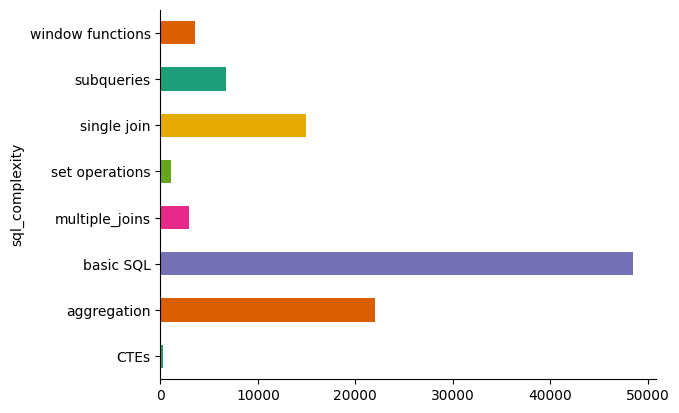

In [15]:
# @title sql_complexity

from matplotlib import pyplot as plt
import seaborn as sns
sql_df.groupby('sql_complexity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Adding your own features

For both raw and fine-tuning data, you may want to add your own featurs to get a better understanding of what's going on in your data and whether there are outliers you want to be concerend about.

## Too many tokens?

String/token length can be a particuarly relevant one since a string that goes beyond the context length of models you want to fine-tune will need some different treatment.

## Application layer
You may already begin to identify things that will be important for the application layer. For example for a natural language to SQL use case we may decide based on the distribution of string/token counts to set some cut offs for what a user can pass in (for example rejecting sql_contexs which are above a certain size).

In [23]:
sql_df['sql_length'] = sql_df['sql'].str.len()
sql_df['sql_context_length'] = sql_df['sql_context'].str.len()

In [24]:
sql_df

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation,sql_length,sql_context_length
0,5097,forestry,Comprehensive data on sustainable forest manag...,single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to...","Joins timber_sales and salesperson tables, gro...",209,436
1,5098,defense industry,"Defense contract data, military equipment main...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen...",This query groups the equipment_maintenance ta...,132,92
2,5099,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...,This query counts the number of marine species...,70,94
3,5100,financial services,Detailed financial data including investment s...,aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)...",This query calculates the total trade value an...,138,127
4,5101,energy,Energy market data covering renewable energy s...,window functions,"window functions (e.g., ROW_NUMBER, LEAD, LAG,...",analytics and reporting,"generating reports, dashboards, and analytical...",Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW...",The SQL query uses the ROW_NUMBER function to ...,120,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,89651,nonprofit,"Nonprofit data on charitable giving trends, so...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",Which programs had the highest volunteer parti...,"CREATE TABLE programs (program_id INT, num_vol...","SELECT program_id, (num_volunteers / total_par...",This query calculates the participation rate f...,132,203
99996,89652,retail,"Retail data on circular supply chains, ethical...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the number of fair-trade certified acc...,"CREATE TABLE products (product_id INT, product...",SELECT COUNT(*) FROM products WHERE is_fair_tr...,The query counts the number of fair-trade cert...,150,362
99997,89653,fitness industry,"Workout data, membership demographics, wearabl...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",Find the user with the longest workout session...,"CREATE TABLE workout_sessions (id INT, user_id...","SELECT u.name, MAX(session_duration) as max_du...",The query joins the workout_sessions and users...,216,152
99998,89654,space exploration,"Spacecraft manufacturing data, space mission r...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",How many space missions were completed by each...,"CREATE TABLE SpaceMissions (id INT, astronaut_...","SELECT a.name, COUNT(sm.id) FROM Astronauts a ...",This query calculates the number of s

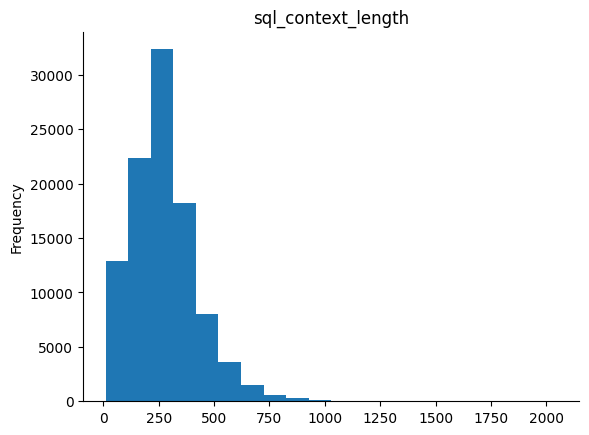

In [25]:
# @title sql_context_length

from matplotlib import pyplot as plt
sql_df['sql_context_length'].plot(kind='hist', bins=20, title='sql_context_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

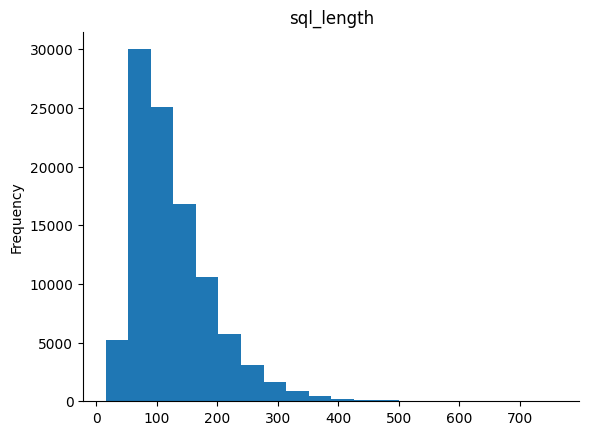

In [20]:
# @title sql_length

from matplotlib import pyplot as plt
sql_df['sql_length'].plot(kind='hist', bins=20, title='sql_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Approach 1: Deduplication using pandas

A niave approach we can take to dropping duplicates (including exact strings) is to use Pandas.


In [28]:
ag_df

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0
119996,Renteria signing a top-shelf deal Red Sox gene...,1
119997,Saban not going to Dolphins yet The Miami Dolp...,1
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1


In [29]:
ag_df.drop_duplicates(subset='text')

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0
119996,Renteria signing a top-shelf deal Red Sox gene...,1
119997,Saban not going to Dolphins yet The Miami Dolp...,1
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1


In [31]:
deduplicated_pandas = sql_df.drop_duplicates(subset='sql')
len(sql_df), len(deduplicated_pandas)

(100000, 99271)

In [ ]:
del df

## Approach 2: Deduplication using hashlib

The Python standard library hashlib can be used to hash strings and then compare them. The `md5` hash can be used to hash strings and then compare them but this hashing function is not designed specifically for string deduplication but it can work sufficiently well for some use cases.

In [36]:
import hashlib

def get_hash(example):
    """Get hash of content field."""
    return {"hash": hashlib.md5(example["sql"].strip().encode("utf-8")).hexdigest()}

def check_uniques(example, uniques):
    """Check if current hash is still in set of unique hashes and remove if true."""
    if example["hash"] in uniques:
        uniques.remove(example["hash"])
        return True
    else:
        return False

def preprocess(example):
    """Chain all preprocessing steps into one function to not fill cache."""
    results = dict()
    results.update(get_hash(example))
    return results

def filter_duplicates(example, uniques):
    """Filter dataset with heuristics. Config, test and has_no_keywords files are removed with a given probability."""
    if not check_uniques(example, uniques):
        return False
    else:
        return True


In [37]:
# Run preprocessing
sql_dataset = sql_dataset.map(preprocess, num_proc=4)

# Deduplicate hashes
uniques = set(sql_dataset.unique("hash"))

# Deduplicate data and apply heuristics
sql_dataset_hashlib_deduped = sql_dataset.filter(filter_duplicates, fn_kwargs={"uniques": uniques})

Map (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [38]:
len(sql_dataset), len(sql_dataset_hashlib_deduped)

(100000, 99269)

## Approach 3: Deduplication using MinHash

> MinHash lets you estimate the Jaccard similarity (resemblance) between sets of arbitrary sizes in linear time using a small and fixed memory space. It can also be used to compute Jaccard similarity between data streams. MinHash is introduced by Andrei Z. Broder in this paper
> [Source](https://ekzhu.com/datasketch/minhash.html)

In [40]:
from datasketch import MinHash

def minhash_signature(text, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for word in text.split():
        m.update(word.encode('utf-8'))
    return m

def preprocess(example):
    signature = minhash_signature(example["sql"])
    # Convert MinHash object to a list of integers for serialization
    hash_values = signature.hashvalues.tolist()
    return {"minhash": hash_values}

processed_dataset = sql_dataset.map(preprocess, num_proc=4)

unique_hashes = set()
def filter_duplicates(example):
    hash_tuple = tuple(example['minhash'])  # Convert list to tuple for hashability
    if hash_tuple in unique_hashes:
        return False
    unique_hashes.add(hash_tuple)
    return True

# Apply filter to remove duplicates
sql_minhash_deduplicated_dataset = processed_dataset.filter(filter_duplicates)

Map (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [ ]:
len(sql_dataset), len(sql_dataset_hashlib_deduped), len(sql_minhash_deduplicated_dataset)

Dataset({
    features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'minhash'],
    num_rows: 99262
})

In [ ]:
len(deduplicated_pandas), len(sql_dataset_hashlib_deduped), len(sql_minhash_deduplicated_dataset)

(99271, 99269, 99262)